
**TESTE**



In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def load_preprocess_and_find_contours(image_path, image_size=(128, 128)):
    img = cv2.imread(image_path)
    if img is not None:
        # Redimensionar imagem
        img_resized = cv2.resize(img, image_size)

        # Converter de BGR para RGB
        img_rgb = cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB)

        # Converter para escala de cinza
        gray_img = cv2.cvtColor(img_resized, cv2.COLOR_BGR2GRAY)

        # Aplicar limiarização
        _, thresh = cv2.threshold(gray_img, 200, 255, cv2.THRESH_BINARY)

        # Encontrar contornos na imagem binarizada
        contours, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

        # Desenhar contornos na imagem original
        img_with_contours = cv2.drawContours(img_rgb.copy(), contours, -1, (0, 255, 0), 2)

        # Adicionar uma dimensão para o batch
        img_with_contours_batch = np.expand_dims(img_with_contours, axis=0)

        return img_with_contours_batch, contours

    return None, None

# Exemplo de uso
image_path = '/content/drive/MyDrive/Colab Notebooks/Laranjas/download (1).jpeg'
processed_image, contours = load_preprocess_and_find_contours(image_path)

# Verificar se a imagem e os contornos foram carregados corretamente
if processed_image is not None and contours is not None:
    print("Formato da imagem pré-processada com contornos:", processed_image.shape)

    # Exibir a imagem com contornos usando Matplotlib
    plt.figure(figsize=(8, 6))
    plt.imshow(processed_image[0])
    plt.title("Imagem com Contornos")
    plt.axis('off')
    plt.show()
else:
    print("Não foi possível carregar a imagem.")


Formato da imagem pré-processada com contornos: (1, 128, 128, 3)


**PROJETO DE CLASSIFICAÇÃO E RECONHECIMENTO DE LARANJAS*

In [52]:
import os
import cv2
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping

# Função para carregar e pré-processar imagens
def load_images_from_folder(folder_path, image_size=(128, 128)):
    images = []
    for filename in os.listdir(folder_path):
        img_path = os.path.join(folder_path, filename)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.GaussianBlur(img, (5, 5), 0)
            img = cv2.resize(img, image_size)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convertendo de BGR para RGB
            images.append(img)
    return np.array(images)

# Função para carregar e pré-processar uma imagem usando OpenCV
def load_and_preprocess_image(image_path, image_size=(128, 128)):
    img = cv2.imread(image_path)
    if img is not None:
        img = cv2.GaussianBlur(img, (5, 5), 0)
        img = cv2.resize(img, image_size)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convertendo de BGR para RGB
        img = np.expand_dims(img, axis=0)  # Adicionando uma dimensão para o batch
    return img

# Definir caminhos para os diretórios contendo as imagens
laranja_folder_path = '/content/drive/MyDrive/Colab Notebooks/Laranjas'
not_laranja_folder_path = '/content/drive/MyDrive/Colab Notebooks/Tangerinas'

# Carregar imagens das pastas
laranja_images = load_images_from_folder(laranja_folder_path)
not_laranja_images = load_images_from_folder(not_laranja_folder_path)

Epoch 1/50
2/2 [==============================] - 7s 3s/step - loss: 0.7064 - accuracy: 0.5577 - val_loss: 5.3005 - val_accuracy: 0.5385
Epoch 2/50
2/2 [==============================] - 6s 2s/step - loss: 4.1584 - accuracy: 0.5192 - val_loss: 0.6913 - val_accuracy: 0.4615
Epoch 3/50
2/2 [==============================] - 5s 3s/step - loss: 0.6908 - accuracy: 0.4808 - val_loss: 0.6837 - val_accuracy: 0.4615
Epoch 4/50
2/2 [==============================] - 6s 2s/step - loss: 0.6837 - accuracy: 0.5577 - val_loss: 0.6405 - val_accuracy: 0.9231
Epoch 5/50
2/2 [==============================] - 5s 3s/step - loss: 0.6590 - accuracy: 0.7500 - val_loss: 0.5702 - val_accuracy: 0.9231
Epoch 6/50
2/2 [==============================] - 6s 3s/step - loss: 0.6297 - accuracy: 0.7308 - val_loss: 0.5303 - val_accuracy: 0.7692
Epoch 7/50
2/2 [==============================] - 5s 2s/step - loss: 0.5727 - accuracy: 0.7500 - val_loss: 0.3665 - val_accuracy: 0.9231
Epoch 8/50
2/2 [=========================

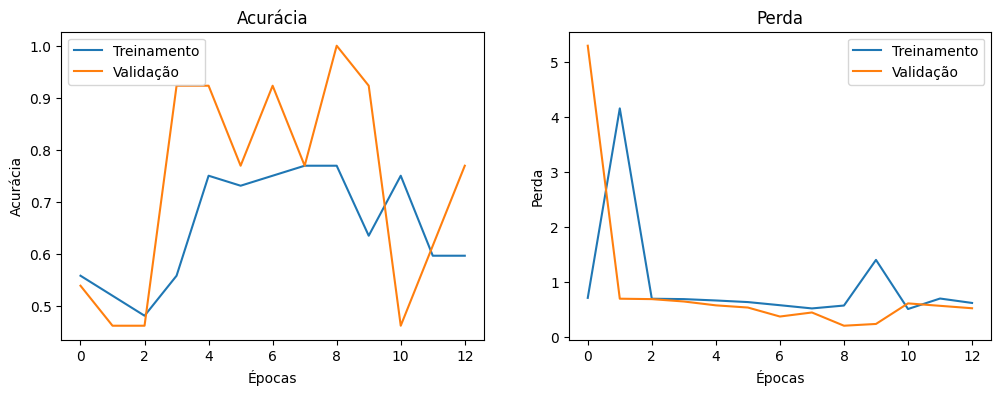

In [89]:
# Criar labels (1 para laranja, 0 para não laranja)
laranja_labels = np.ones(len(laranja_images))
not_laranja_labels = np.zeros(len(not_laranja_images))

# Combinar dados e labels
X = np.concatenate((laranja_images, not_laranja_images), axis=0)
y = np.concatenate((laranja_labels, not_laranja_labels), axis=0)

# Dividir o conjunto de dados em treinamento e validação
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalizar os valores dos pixels
X_train = X_train / 255.0
X_val = X_val / 255.0

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Definir o modelo
model = tf.keras.Sequential([
    # Aumentar o número de filtros pode capturar mais características
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    # Reduzir o tamanho do pooling preserva mais detalhes das características, mas pode aumentar o risco de overfitting
    tf.keras.layers.MaxPooling2D((2, 2)),
    #  Aumentar o número de neurônios nas camadas densas pode aumentar a capacidade do
    # modelo de aprender relações complexas,mas também aumenta a possibilidade de overfitting e
    # aumenta o tempo de treinamento
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    # função ativação
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')  # Para classificação binária
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Early stopping para interromper o treinamento se não houver melhoria na validação
early_stopping = EarlyStopping(
    monitor='val_loss',   # Monitora a perda nos dados de validação
    patience=4,            # Número de epochs sem melhoria permitido
    restore_best_weights=True  # Restaura os melhores pesos após o treinamento
)

# Treinamento do modelo com data augmentation e early stopping
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),  # Utiliza o gerador de dados aumentados
    validation_data=(X_val, y_val),  # Dados de validação
    epochs=50,  # Número de épocas de treinamento
    callbacks=[early_stopping]  # Lista de callbacks, incluindo early stopping
)

# Salvar o modelo treinado
model.save('/content/saved_model.h5')

# Plotar a acurácia e a perda do treinamento e validação
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Treinamento')
plt.plot(history.history['val_accuracy'], label='Validação')
plt.title('Acurácia')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Treinamento')
plt.plot(history.history['val_loss'], label='Validação')
plt.title('Perda')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()

plt.show()

1/1 [==============================] - 0s 113ms/step
A imagem é de uma laranja.


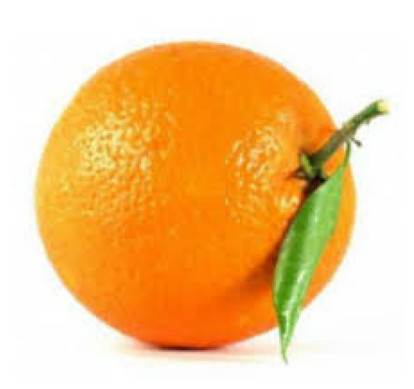

In [54]:
# Função para carregar o modelo e fazer predições
def predict_image(model, image_path):
    # Carregar e pré-processar a imagem
    img = load_and_preprocess_image(image_path)

    # Fazer a predição
    prediction = model.predict(img)

    # Interpretar a predição
    if prediction[0] > 0.5:
        print("A imagem é de uma laranja.")
    else:
        print("A imagem não é de uma laranja.")

    # Exibir a imagem
    plt.imshow(cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

# Defina o caminho para a imagem de teste
test_image_path = '/content/teste.jpg'

# Carregar o modelo treinado
model = tf.keras.models.load_model('/content/saved_model.h5')

# Fazer a predição na imagem de teste
predict_image(model, test_image_path)